## PySteps `STEPS` nowcast evaluation.
* This notebook evaluates the PySTEPS `STEPS` nowcast on the IMERG test dataset.

* The evaluation metrics are the same as DYfusion and ConvLSTM. 

* The evaluated STEPS approach is roll-out inference to better align with the `DYffusion` sampling. For STEPS, we use the previous 4 IMERG images @ 30-minute intervals (2 hours) to compute the motion vector field and then apply the STEPS method. The process looks like:

[1] **roll-out process:**
```
# [ [x] [x] [x] [x] ] --> [y1]
# [     [x] [x] [x]       [y1]] --> [y2]
# [         [x] [x]       [y1]      [y2]] --> [y3]
# [             [x]       [y1]      [y2]      [y3]] --> [y4]
# ...
```

In [1]:
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple

from IPython.display import clear_output
from livelossplot import PlotLosses
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xarray as xr
import xskillscore as xs
from scipy import io
from torch.nn import L1Loss, MSELoss
from torch.utils.data import DataLoader
from torchmetrics.image import LearnedPerceptualImagePatchSimilarity as LPIPS
from torchmetrics.regression import CriticalSuccessIndex
from tqdm import tqdm

from rainnow.src.pysteps_steps import PyStepsNowcastModel
from rainnow.src.conv_lstm_utils import (
    IMERGDataset,
    create_eval_loader,
    plot_predicted_sequence,
    save_checkpoint,
    train,
    validate,
)
from rainnow.src.loss import CBLoss, LPIPSMSELoss
from rainnow.src.models.conv_lstm import ConvLSTMModel
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import (
    get_device,
    transform_0_1_to_minus1_1,
    transform_minus1_1_to_0_1,
)

from rainnow.src.dyffusion.utilities.evaluation import (
    evaluate_ensemble_crps,
    evaluate_ensemble_spread_skill_ratio,
)

Pysteps configuration file found at: /teamspace/studios/this_studio/.pysteps/pystepsrc



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


#### `helpers.`

In [2]:
# ** DIR helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CKPT_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/results/"
CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataset Params **
REVERSE_PROBABILITY = 0.1

# ** Dataloader Params **
BATCH_SIZE = 12
NUM_WORKERS = 0

INPUT_SEQUENCE_LENGTH = 4
OUTPUT_SEQUENCE_LENGTH = 1
INPUT_DIMS = (1, 128, 128)  # C, H, W

# ** plotting helpers **
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# ** get device **
device = get_device()

Cuda installed! Running on GPU! (device = cuda)


#### `Instantiate + Load in the datamodule`

In [3]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["0,0", "1,0", "2,0", "2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
        "normalization": None,  # set normalisation to None. Need raw mm/h for the STEPS nowcast.
    },
)

datamodule.setup("test")

[2024-11-28 15:45:57][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-11-28 15:45:57][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-11-28 15:46:02][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-11-28 15:46:02][abstract_datamodule.py][INFO] -->  Dataset test size: 984


#### `Create the test_dataset`

In [4]:
# create the datasets.
test_dataset = IMERGDataset(
    datamodule, "test", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

#### `Instantiate the preprocessor object`

In [5]:
# instantiate the datamodule so that we can access the scaling / normalisation params.
tmp_datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
)

# ** instantiate the preprocesser obj **
pprocessor = PreProcess(
    percentiles=tmp_datamodule.normalization_hparams["percentiles"],
    minmax=tmp_datamodule.normalization_hparams["min_max"],
)

[2024-11-28 15:46:02][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


#### `Get Metrics`

In [6]:
# instantiate metrics.
lpips = LPIPS(reduction="mean", normalize=True).to(
    device
)  # set to True so that the function normalises to [-1, 1].
mse = MSELoss(reduction="mean")

# don't need to preprocess these as we are staying in mm/h.
csi_nodes = [2, 10, 18]
csi2 = CriticalSuccessIndex(threshold=csi_nodes[0]).to(device)
csi10 = CriticalSuccessIndex(threshold=csi_nodes[1]).to(device)
csi18 = CriticalSuccessIndex(threshold=csi_nodes[-1]).to(device)

#### `Evaluation Metrics: entire TEST dataset`

In [7]:
# ** create the eval dataloader **
eval_loader, _ = create_eval_loader(
    data_loader=test_loader, horizon=8, input_sequence_length=4, img_dims=(128, 128)
)

** eval loader (INFO) **
Num samples = 1228 w/ dims: torch.Size([12, 1, 128, 128])



In [8]:
HORIZON = 30 * 1  # roll-out.
DATA_FREQUENCY = 30  # in min.
SPATIAL_RESOLUTION = 10  # in km.
NUM_ENSEMBLE = 10
CONVERT_TO_dBR = True
MM_H_PRECIP_THD = 0.1
DBR_PRECIP_THD = -15

In [9]:
# ** evaluate 101 **
eval_metrics = {}
results = []
for e, (X, target) in enumerate(eval_loader):
    ens_predictions = {}
    predictions = {}
    for t in range(target.size(0)):
        # instantiate PySteps model using X.
        pysteps_model = PyStepsNowcastModel(
            input_precip_sequence=X,
            input_dims=INPUT_DIMS,  # c, h, w.
            horizon=HORIZON,  # in min
            data_time_interval=DATA_FREQUENCY,
            data_km_per_pixel_resolution=SPATIAL_RESOLUTION,
            num_ensemble=NUM_ENSEMBLE,
            transform_mm_h_to_dBR=CONVERT_TO_dBR,
        )

        # STEPS nowcast.
        R_f = pysteps_model.nowcast(
            mm_h_precip_threshold=MM_H_PRECIP_THD,
            dBR_precip_threshold=DBR_PRECIP_THD,
            n_cascade_levels=6,
            noise_method="nonparametric",  # adds stochastic noise to represent growth/decay.
            vel_pert_method="bps",  # If set to None, the advection field is not perturbed.
            mask_method="incremental",  # "sprog",
        )

        # (N, t, C, H, W)
        R_f = torch.from_numpy(R_f).unsqueeze(1)

        # get mean of ensemble (dims: (N, t, C, H, W)
        pred = torch.mean(R_f, dim=0)

        # store the predictions.
        predictions[f"t{t+1}"] = pred
        ens_predictions[f"t{t+1}"] = R_f

        # update the inputs with the last mu pred.
        X = torch.concat([X[1:, ...], pred], dim=0)

        # clear STEPS outputs.
        clear_output(wait=True)

    results.append([target, predictions, ens_predictions])

# generate correct shape prediction lists to make eval easier.
targets_list = []
preds_list = []
ens_preds_list = []
for e, (target, mu_preds, ens_t_preds) in enumerate(results):
    # (t, C, H, W).
    mu_pred = torch.cat([v for _, v in mu_preds.items()], dim=0)
    preds_list.append(mu_pred)

    # (N, t, C, H, W).
    ens_pred = torch.stack([v for _, v in ens_t_preds.items()]).permute(1, 0, 2, 3, 4, 5).squeeze(3)
    assert ens_pred.size(0) == NUM_ENSEMBLE
    ens_preds_list.append(ens_pred)

    # (t, C, H, W).
    targets_list.append(target)

assert len(targets_list) == len(preds_list) == len(ens_preds_list)

NameError: name 'ens_preds' is not defined

#### `Eval Metrics` 

In [11]:
# ** calculate metrics for each preds / target pair **
# reset metrics for eack ckpt id.
# overall metrics for target and prediction.
l2_score = 0
lpips_score = 0
csi2_score = 0  # low rain.
csi10_score = 0  # mid rain.
csi18_score = 0  # heavy rain.
raw_crps_score = 0
crps_score = 0
ssr_score = 0

error_preds = []
for idx in range(len(targets_list)):
    # get preds and targets.
    _pred = preds_list[idx]
    _ens_preds = ens_preds_list[idx]
    _target = targets_list[idx]

    try:
        # ** get metrics **
        # 1. mse.
        l2_score += mse(_pred.to(device), _target.to(device))

        # 2. lpips.
        # need to get lpips inputs into ~ [0, 1] range.
        # using the training preprocessing pipeline, atleast the pred and target will
        # be transformed to the same scale.
        target_lpips = pprocessor.apply_preprocessing(_target)
        pred_lpips = pprocessor.apply_preprocessing(_pred)

        # lpips score. Inputs need to have 3 channels.
        lpips_score += lpips(
            torch.clamp(pred_lpips.expand(-1, 3, -1, -1), 0, 1).float().to(device),
            torch.clamp(target_lpips.expand(-1, 3, -1, -1), 0, 1).float().to(device),
        )

        # 3. csi score (at different thresholds).
        csi2_score += csi2(_pred.to(device), _target.to(device))
        csi10_score += csi10(_pred.to(device), _target.to(device))
        csi18_score += csi18(_pred.to(device), _target.to(device))

        # 4. CRPS & SSR (probabilistic metrics).
        raw_crps_score += evaluate_ensemble_crps(ensemble_predictions=_ens_preds, targets=_target)
        # crps when data is ~ [0, 1].
        crps_score += evaluate_ensemble_crps(
            ensemble_predictions=pprocessor.apply_preprocessing(_ens_preds),
            targets=pprocessor.apply_preprocessing(_target),
        )
        ssr_score += evaluate_ensemble_spread_skill_ratio(
            ensemble_predictions=_ens_preds.numpy(), targets=_target.numpy()
        )

    # handle errors.
    except (ValueError, RuntimeError, torch.cuda.OutOfMemoryError) as e:
        print(f"Error at index {idx}: {str(e)}")
        error_preds.append([idx, _preds, _ens_preds, str(e)])  # Store the error message too
    except Exception as e:
        print(f"Unexpected error at index {idx}: {e.__class__.__name__}: {str(e)}")
        error_preds.append([idx, _preds, _ens_preds, f"{e.__class__.__name__}: {str(e)}"])


eval_metrics = {
    "MSE": l2_score.item() / len(eval_loader),
    "lpips": lpips_score.item() / len(eval_loader),
    "csi2": csi2_score.item() / len(eval_loader),
    "csi10": csi10_score.item() / len(eval_loader),
    "csi18": csi18_score.item() / len(eval_loader),
    "raw_crps": raw_crps_score / len(eval_loader),
    "crps": crps_score / len(eval_loader),
    "ssr": ssr_score / len(eval_loader),
}

# create df, format it and export it to a .csv.
df_results = pd.DataFrame(eval_metrics, index=["steps"])
df_results[["MSE", "lpips", "csi2", "csi10", "csi18", "raw_crps", "crps", "ssr"]]

,MSE,lpips,csi2,csi10,csi18,raw_crps,crps,ssr
steps,2.41017,0.342368,0.13972,0.030162,0.010549,0.339665,0.012899,0.21854


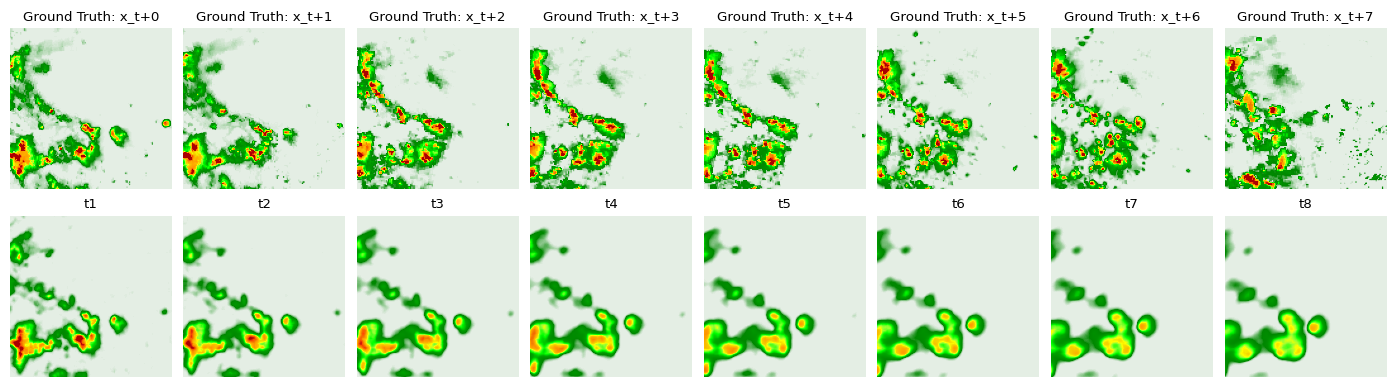

In [17]:
# plot the predictions:
c = 0
figsize = (14, 4)
plot_params = {"cmap": rain_cmap, "vmin": 0.0, "vmax": 18}

idx = 1

targets, predictions, _ = results[idx]
predictions = {k: v for k, v in predictions.items()}

fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)
# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(targets[j, c, ...], **plot_params)
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")
# plot predictions.
for e, (k, pred) in enumerate(predictions.items()):
    axs[1, e].imshow(pred[0, c, :, :], **plot_params)
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()

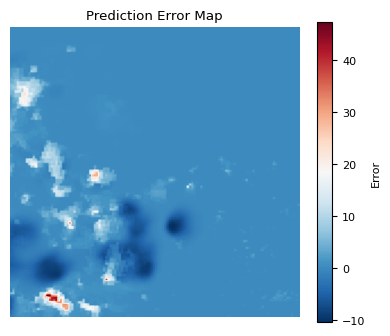

In [21]:
# check the error as the MSE is so high.
# seems like the magnitude is getting massively under-predicted using STEPS.
fig, ax = plt.subplots(figsize=(4, 4))
i = 7
im = ax.imshow(targets[i, c, ...] - predictions[f"t{i}"][0, 0, :, :], cmap="RdBu_r")
cbar = fig.colorbar(im, label="Error", shrink=0.8)  # Make colorbar 80% of original size
ax.set_title("Prediction Error Map")
ax.axis("off")
plt.tight_layout()

#### `Eval Metrics (CSI / t)` 

In [22]:
# create csi stores.
csi2_score_t = torch.zeros(target.size(0)).to(device)
csi10_score_t = torch.zeros(target.size(0)).to(device)
csi18_score_t = torch.zeros(target.size(0)).to(device)

# perceptual loss scores.
lpips_score_t = torch.zeros(target.size(0)).to(device)

for targets, predictions in zip(targets_list, preds_list):
    assert targets.size() == predictions.size()  # (t, C, H, W).
    for t in range(targets.size(0)):

        t_target = targets[t, ...].to(device)
        t_pred = predictions[t, ...].to(device)

        # loop through all the ts and compute the relevant CSI scores.
        csi2_score_t[t] += csi2(t_target, t_pred)
        csi10_score_t[t] += csi10(t_target, t_pred)
        csi18_score_t[t] += csi18(t_target, t_pred)

        target_lpips = pprocessor.apply_preprocessing(t_target).unsqueeze(0)
        pred_lpips = pprocessor.apply_preprocessing(t_pred).unsqueeze(0)
        # lpips score. Inputs need to have 3 channels.
        lpips_score_t[t] += lpips(
            torch.clamp(target_lpips.expand(-1, 3, -1, -1), 0, 1).float().to(device),
            torch.clamp(pred_lpips.expand(-1, 3, -1, -1), 0, 1).float().to(device),
        )

# normalise the scores.
eval_metrics_per_t = {
    "csi2_t": csi2_score_t.cpu() / len(eval_loader),
    "csi10_t": csi10_score_t.cpu() / len(eval_loader),
    "csi18_t": csi18_score_t.cpu() / len(eval_loader),
    "lpips_t": lpips_score_t.cpu() / len(eval_loader),
}

# create df, format it and export it to a .csv.
df_results_per_t = pd.DataFrame(eval_metrics_per_t).T
df_results_per_t.to_csv("pysteps_steps_per_t_metrics.csv")

In [23]:
# get csi + lpips dfs.
dfs = {}
for metric, values in eval_metrics_per_t.items():
    dfs[metric] = pd.DataFrame(
        data=[[i.item() for i in values]], columns=[f"t{i+1}" for i in range(len(values))]
    )

df_csi2 = pd.DataFrame(columns=[f"t{i+1}" for i in range(targets.size(0))])
df_csi10 = pd.DataFrame(columns=[f"t{i+1}" for i in range(targets.size(0))])
df_csi18 = pd.DataFrame(columns=[f"t{i+1}" for i in range(targets.size(0))])
df_lpips = pd.DataFrame(columns=[f"t{i+1}" for i in range(targets.size(0))])

df_csi2.loc[0] = dfs["csi2_t"].iloc[0].values
df_csi10.loc[0] = dfs["csi10_t"].iloc[0].values
df_csi18.loc[0] = dfs["csi18_t"].iloc[0].values
df_lpips.loc[0] = dfs["lpips_t"].iloc[0].values

In [24]:
df_csi2

,t1,t2,t3,t4,t5,t6,t7,t8
0,0.356563,0.234885,0.165379,0.12278,0.095088,0.074767,0.058451,0.04819


In [25]:
df_csi10

,t1,t2,t3,t4,t5,t6,t7,t8
0,0.112525,0.04082,0.019884,0.010119,0.006053,0.00353,0.001689,0.001115


In [26]:
df_csi18

,t1,t2,t3,t4,t5,t6,t7,t8
0,0.036314,0.008043,0.002878,0.001021,0.000519,0.00021,0.00029,0.000052


In [27]:
df_lpips

,t1,t2,t3,t4,t5,t6,t7,t8
0,0.203697,0.29041,0.33539,0.358073,0.373383,0.385745,0.396194,0.399058


### END OF SCRIPT.